In [5]:
# When in Kaggle only: Run this first, everytime. Then restart by selecting clear and run and DO NOT FACTORY RESET 
# !pip install -U tensorflow==2.13.1

In [6]:
# pip install tensorflow

In [7]:
# pip install keras

In [8]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

##### Replace with relative path

In [9]:
# df = pd.read_csv('/kaggle/input/kappa-labeled-train-2/kappa_labeled_train.csv')
df = pd.read_csv('../Data/kappa_labeled_train.csv')

In [10]:
df['cohen_kappa_label'].value_counts(normalize=True)

cohen_kappa_label
0.2    0.482409
0.5    0.250343
0.3    0.174098
0.6    0.065367
0.4    0.010780
0.0    0.010241
0.7    0.003724
0.1    0.002940
0.6    0.000049
0.8    0.000049
Name: proportion, dtype: float64

#### Rebin Values - Do not Run / Use

In [11]:

df['cohen_kappa_label_reformatted'] = pd.cut(df['cohen_kappa_label'],
                                              bins=[-float('inf'), 0.1, 0.2, 0.4, 0.6, 0.8, float('inf')],
                                              labels=[0.0,0.2, 0.4, 0.6, 0.8, 1.0],
                                              right=True)

# Display the reformatted column
print(df[['cohen_kappa_label', 'cohen_kappa_label_reformatted']])
print(df['cohen_kappa_label_reformatted'].value_counts(normalize=True))

       cohen_kappa_label cohen_kappa_label_reformatted
0                    0.2                           0.2
1                    0.0                           0.0
2                    0.2                           0.2
3                    0.5                           0.6
4                    0.2                           0.2
...                  ...                           ...
20403                0.2                           0.2
20404                0.2                           0.2
20405                0.2                           0.2
20406                0.2                           0.2
20407                0.6                           0.8

[20408 rows x 2 columns]
cohen_kappa_label_reformatted
0.2    0.482409
0.6    0.250392
0.4    0.184878
0.8    0.069140
0.0    0.013181
1.0    0.000000
Name: proportion, dtype: float64


In [12]:
df['cohen_kappa_label_reformatted'].value_counts(normalize=True)

cohen_kappa_label_reformatted
0.2    0.482409
0.6    0.250392
0.4    0.184878
0.8    0.069140
0.0    0.013181
1.0    0.000000
Name: proportion, dtype: float64

In [13]:
df.head()

,Unnamed: 0.1,Unnamed: 0,abstracts_headlines,section_name,cohen_kappa_label,cohen_kappa_range_none_to_slight,cohen_kappa_range_fair,cohen_kappa_range_moderate,cohen_kappa_range_substantial,cohen_kappa_range_almost_perfect,cohen_kappa_range_nan,cohen_kappa_label_reformatted
0,0,0,new start treaty nearly wrapped president obam...,1,0.2,1,0,0,0,0,0,0.2
1,1,1,response plea israel release jonathan pollard ...,1,0.0,0,0,0,0,0,1,0.0
2,2,2,letters editor regarding tensions new york med...,1,0.2,1,0,0,0,0,0,0.2
3,3,3,canada beat united states semifinals world jun...,0,0.5,0,0,1,0,0,0,0.6
4,4,4,kristine lilly holds world record internationa...,0,0.2,1,0,0,0,0,0,0.2


In [14]:
# Remove Stopwords and create two lists containing headlines/articles and their labels
articles = []
labels = []

for index, row in df.iterrows():
  labels.append(row['cohen_kappa_label'])

  token_list = [x for x in row['abstracts_headlines'].split() if x not in stopwords.words('english')]

  articles.append(" ".join(token_list))

### Train Test Modeling Prerequisites

In [15]:
X_train, X_test, y_train, y_test = train_test_split(articles, labels, random_state=42, test_size=0.2)

In [16]:
# Define variables

 # Max number of words
 # Word Vector dimension
 # Max length of the sequence
 # Where to chop off the seq
 # Where to put padding
 # Define some variables
vocab_size = 23100 # max number of words equiv of max_features for vectorizers
embedding_dim = 100 # this is the dimension of the Word Vector
max_length = 78 # maximum length of the sequence
trunc_type = 'post' # where to cut off
padding_type = 'post' # where to put the padding
oov_token = '<OOV>'

'''
print(vocab_size)
print(embedding_dim)
print(max_length)
23081
100
77
'''

'\nprint(vocab_size)\nprint(embedding_dim)\nprint(max_length)\n23081\n100\n77\n'

#### Tokenize

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_token)

#### Fit Tokenizer

In [18]:
tokenizer.fit_on_texts(X_train)

In [19]:
tokenizer.word_index;

#### Sequence train

In [20]:
train_seq = tokenizer.texts_to_sequences(X_train)

#### Pad Sequence

In [21]:
train_padded = pad_sequences(train_seq, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [22]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [23]:
X_test_precoded = X_test
y_test_precoded = y_test

#### Label Encoder

### When joining preds with test to check as a dataframe don't run these following transforms

In [24]:
le = LabelEncoder()


y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [25]:
y_test[:15]

array([2, 2, 2, 3, 2, 2, 5, 5, 2, 2, 3, 3, 3, 2, 2])

In [26]:
le.classes_

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.7, 0.8])

#### Create Categories

In [27]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [28]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Initial Attempt

In [29]:
from tensorflow.keras.optimizers import schedules

##### Replace output layer with the number of your label classes - original model used 5 but this current model uses 10 etc. etc. 

In [30]:
model_11 = Sequential()
model_11.add(Embedding(vocab_size, embedding_dim))
model_11.add(Bidirectional(LSTM(64, return_sequences=True)))
model_11.add(Dropout(0.1))
model_11.add(Bidirectional(LSTM(32)))
model_11.add(Dropout(0.1))
model_11.add(Dense(8, activation='relu'))  # Added a dense layer with two that sum to 16 this is better than a single of 16 try 4 with 4
model_11.add(Dropout(0.1))
model_11.add(Dense(8, activation='relu'))  # Added a dense layer
model_11.add(Dropout(0.1))
model_11.add(Dense(10, activation='softmax'))

initial_learning_rate = 0.005
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.7, staircase=True
)

optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)

model_11.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', 'mse'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_11 = model_11.fit(
    train_padded, y_train,
    validation_data=(test_padded, y_test),
    batch_size=512,
    epochs=35,  # Set a smaller number of epochs
    verbose='auto',
    callbacks=[early_stopping]
)


Epoch 1/35
32/32 [==============================] - 40s 1s/step - loss: 1.8270 - acc: 0.3220 - mse: 0.0784 - val_loss: 1.3228 - val_acc: 0.5943 - val_mse: 0.0582
Epoch 2/35
32/32 [==============================] - 30s 925ms/step - loss: 1.2224 - acc: 0.5837 - mse: 0.0564 - val_loss: 1.0797 - val_acc: 0.6210 - val_mse: 0.0512
Epoch 3/35
32/32 [==============================] - 29s 900ms/step - loss: 0.9281 - acc: 0.6575 - mse: 0.0457 - val_loss: 1.0106 - val_acc: 0.6328 - val_mse: 0.0492
Epoch 4/35
32/32 [==============================] - 28s 870ms/step - loss: 0.7260 - acc: 0.7105 - mse: 0.0365 - val_loss: 1.0907 - val_acc: 0.6541 - val_mse: 0.0484
Epoch 5/35
32/32 [==============================] - 28s 888ms/step - loss: 0.5543 - acc: 0.8118 - mse: 0.0268 - val_loss: 1.0856 - val_acc: 0.6497 - val_mse: 0.0464
Epoch 6/35
32/32 [==============================] - 28s 878ms/step - loss: 0.4202 - acc: 0.8611 - mse: 0.0195 - val_loss: 1.1848 - val_acc: 0.6862 - val_mse: 0.0455
Epoch 7/35
32

##### Plot to visualize performance 

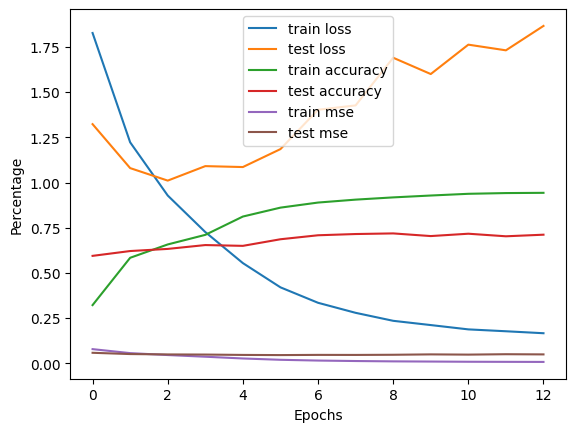

In [31]:
plt.plot(history_11.history['loss'], label='train loss')
plt.plot(history_11.history['val_loss'], label='test loss')
plt.plot(history_11.history['acc'], label='train accuracy')
plt.plot(history_11.history['val_acc'], label='test accuracy')
plt.plot(history_11.history['mse'], label='train mse')
plt.plot(history_11.history['val_mse'], label='test mse')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend()
plt.show;

# Evaluate the model¶


In [32]:
pred = np.argmax(model_11.predict(test_padded), axis = 1)


128/128 [==============================] - 4s 16ms/step


In [33]:
pred_labels = le.inverse_transform(pred)


In [34]:
np.mean(pred_labels)

0.30053895149436555

# Use the following for entries to reference in order to test the streamlit app

In [35]:
pred_labels = le.inverse_transform(pred) 

# Create a new DataFrame - Now do not need to run top cells
test_combined_df = pd.DataFrame({'Articles': X_test_precoded, 'Actual Labels': y_test_precoded, 'Predicted Labels': pred_labels})

In [36]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

test_combined_df

,Articles,Actual Labels,Predicted Labels
0,amid logistical challenges voting pandemic despite threats foreign interference violence disinformation machinery democracy held quite well warnings could go rails election actually ran smoothly,0.2,0.2
1,readers vented frustration political system cheered elizabeth warren combative rhetoric status quo reaction david brooks column warren win readers respond warren win,0.2,0.2
2,new accord denies permanently rule south korea right enrich uranium reprocess spent nuclear fuel even peaceful purposes u south korea reach revised nuclear deal,0.2,0.2
3,optimistic possible supreme court ruling law lawmakers giving past proposals second look lowering health costs priority looking ahead republicans examine options health care fight,0.3,0.2
4,f b scored two major victories recovering bitcoin ransom tricking lawbreakers encryption app criminals may still upper hand bitcoin encryption race criminals f b,0.2,0.2
...,...,...,...
4077,christian conservatives dealing loss presidency also many see rejection agenda including fights sex marriage christian right failed sway voters issues,0.2,0.2
4078,even people try get recognition social awareness others calling trying score points earning woke badge,0.2,0.5
4079,judge clay jenkins dallas county chief executive said people contact thomas eric duncan cleared overnight twice daily monitoring days showing symptoms u ebola watch list cleared,0.2,0.2
4080,agnostic guide president strange conduct trump russia one mystery three theories,0.3,0.2


##### Uncomment to save model, recommend using `h5` for `Streamlit` compatibility. 

In [38]:
# Ready to save - uncomment
model_11.save('model_11.h5')
# model_11.save('model_11_72test.keras')


/Users/ben/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
